# Pneumonia X-ray image analysis

Download the dataset from this kaggel link:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [ ]:
'''
# RUN ALL these commands in TERMINAL, not in the notebook.
!python3.12 -m venv .venv
!.venv\scripts\activate

Add lines of code to the follwing to further install necessary libraries

!python -m pip install matplotlib
!python -m pip install scikit-learn
!python -m pip install opencv-python

'''


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ma053309\AppData\Local\Temp\ipykernel_26128\2812820218.py:2: SyntaxWarning: invalid escape sequence '\s'
  !.venv\scripts\activate


'!python3.12 -m venv .venv\n!.venv\\scripts\x07ctivate\n\nAdd lines of code to the follwing to further install necessary libraries\n\n!python -m pip install matplotlib\n!python -m pip install scikit-learn\n!python -m pip install opencv-python\n\n'

In [6]:
%matplotlib inline 
import os
import tensorflow as tf
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("tensorflow", tf.__version__)

tensorflow 2.20.0


In [7]:
# Training settings
batch_size = 128
img_height = 128
img_width = 128

# Data

In [8]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
# val_dir = 'chest_xray/val'

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


The following block retrieves images from a subdirectory.

The function returns:

    train_label_count: number of classes

    train_label_names: names of classes

    train_data: read images as a list in matrices xdim*ydim

    train_labels: numbered labels as a list

https://www.kaggle.com/laurajezequel/pneumonia-detection

In [16]:
import cv2
import os
import glob
import gc

def lire_images(img_dir, xdim, ydim, nmax=5000) :
    train_label_count = 0
    train_label_names = []
    train_data = []
    train_labels=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        train_label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>nmax : break
            img = cv2.imread(f1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (xdim,ydim)) 
            train_data.append(np.array(img)) 
            train_labels.append(train_label_count) 
            n=n+1
        print(n,' images')
        train_label_count = train_label_count+1
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)

    return train_data,train_labels, train_label_count, train_label_names

In [17]:
train_data,train_labels,label_count,label_names = lire_images("chest_xray/train", 128, 128, 2836)

NORMAL
1341  images
PNEUMONIA
2837  images


In [18]:
print(train_data[0])

[[[22 22 22]
  [20 20 20]
  [16 16 16]
  ...
  [94 94 94]
  [95 95 95]
  [93 93 93]]

 [[22 22 22]
  [18 18 18]
  [17 17 17]
  ...
  [93 93 93]
  [92 92 92]
  [92 92 92]]

 [[22 22 22]
  [16 16 16]
  [17 17 17]
  ...
  [93 93 93]
  [91 91 91]
  [89 89 89]]

 ...

 [[32 32 32]
  [33 33 33]
  [28 28 28]
  ...
  [30 30 30]
  [32 32 32]
  [32 32 32]]

 [[31 31 31]
  [27 27 27]
  [26 26 26]
  ...
  [58 58 58]
  [58 58 58]
  [56 56 56]]

 [[42 42 42]
  [42 42 42]
  [39 39 39]
  ...
  [95 95 95]
  [96 96 96]
  [97 97 97]]]


In [19]:
print(train_labels[:10]) # categories
print(label_count) # number of categories
print(label_names) # names of categories

[0 0 0 0 0 0 0 0 0 0]
2
['NORMAL', 'PNEUMONIA']


Random images are selected from the crowd

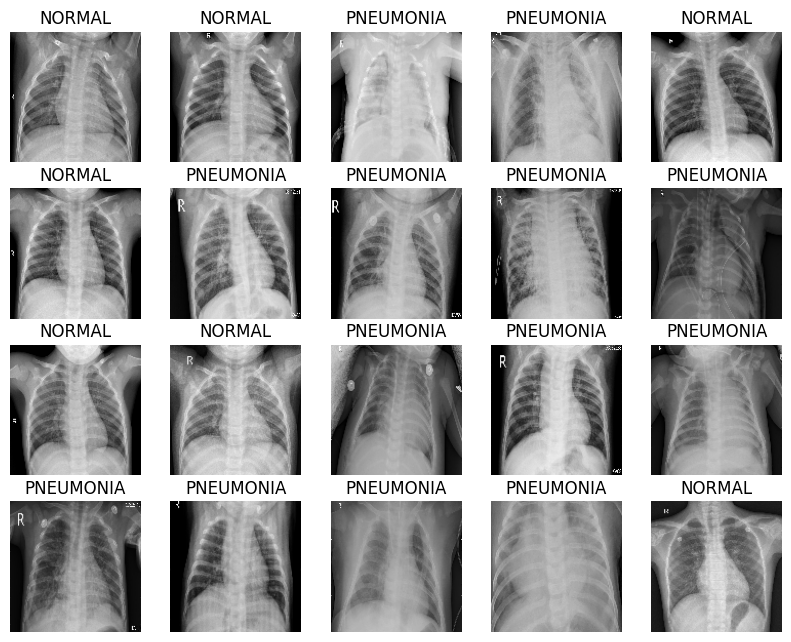

In [25]:
import random
plt.figure(figsize=(10,20))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    j = random.randint(0,len(train_data))
    plt.axis('off')
    plt.imshow(train_data[j])
    plt.title(label_names[train_labels[j]])

The following block uses the methods of TensorFlow's tf.data module to improve data loading and processing performance during training. The functions used are cache(), shuffle(), and prefetch().

    train_ds = train_ds.cache(): uses the cache() method to cache the data. When the first epoch (epoch) with the data is performed, data loading and processing is faster because some or all of the data is already in the cache.

    train_ds = train_ds.shuffle(1000): shuffles the data using the shuffle() method so that the model learns generalizable features and is not dependent on the order of the data.

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE): uses the prefetch() method, which loads and processes the data in advance (asynchronously), which reduces waiting times during training. TensorFlow automatically estimates the optimal buffer size (autotune)

In [21]:
# Speeding up the data processing
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>